In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
! kaggle datasets download -d sujallimje/plant-pathogens

Dataset URL: https://www.kaggle.com/datasets/sujallimje/plant-pathogens
License(s): CC-BY-NC-SA-4.0
100% 23.7G/23.7G [03:54<00:00, 147MB/s]
100% 23.7G/23.7G [03:54<00:00, 109MB/s]


In [3]:
!unzip /content/plant-pathogens.zip

Streaming output truncated to the last 5000 lines.
  inflating: pathogen/virus/vir (5499).JPG  
  inflating: pathogen/virus/vir (55).JPG  
  inflating: pathogen/virus/vir (550).JPG  
  inflating: pathogen/virus/vir (5500).JPG  
  inflating: pathogen/virus/vir (5501).JPG  
  inflating: pathogen/virus/vir (5502).JPG  
  inflating: pathogen/virus/vir (5503).JPG  
  inflating: pathogen/virus/vir (5504).JPG  
  inflating: pathogen/virus/vir (5505).JPG  
  inflating: pathogen/virus/vir (5506).JPG  
  inflating: pathogen/virus/vir (5507).JPG  
  inflating: pathogen/virus/vir (5508).JPG  
  inflating: pathogen/virus/vir (5509).JPG  
  inflating: pathogen/virus/vir (551).JPG  
  inflating: pathogen/virus/vir (5510).JPG  
  inflating: pathogen/virus/vir (5511).JPG  
  inflating: pathogen/virus/vir (5512).JPG  
  inflating: pathogen/virus/vir (5513).JPG  
  inflating: pathogen/virus/vir (5514).JPG  
  inflating: pathogen/virus/vir (5515).JPG  
  inflating: pathogen/virus/vir (5516).JPG  
  inflat

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import pandas as pd, numpy as np

In [5]:
img_size = 256
BATCH_SIZE = 150
Channels = 3
EPOCHS = 5

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'pathogen/',
    shuffle = True,
    image_size = (img_size,img_size),
    batch_size = BATCH_SIZE

)

Found 176744 files belonging to 5 classes.


In [7]:
class_names = dataset.class_names
class_names

['bacteria', 'fungus', 'healthy', 'pests', 'virus']

In [8]:
len(dataset)

1179

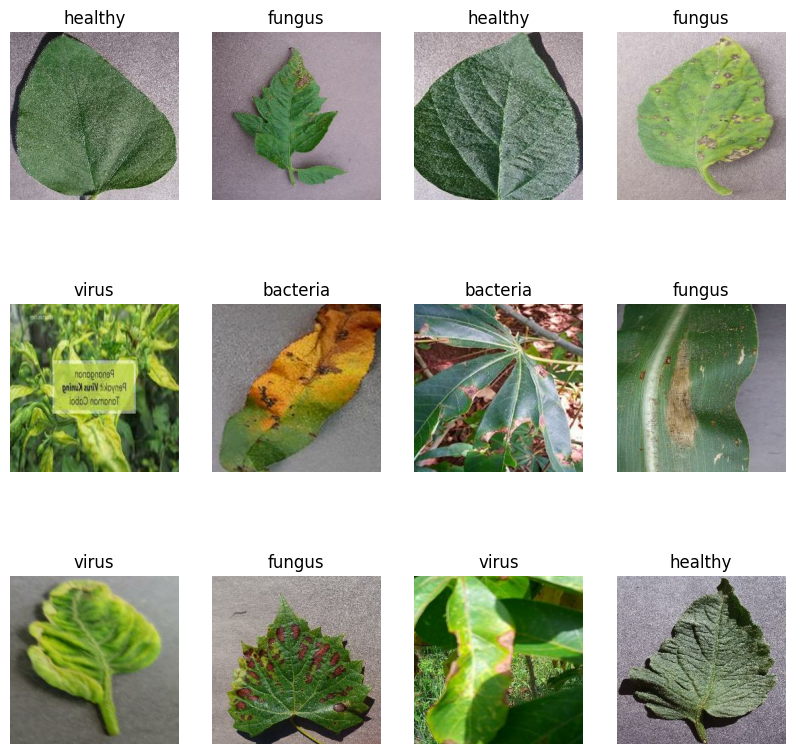

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('int'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [10]:
def split_train_test(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  data_size = len(data)

  if shuffle:
    data = data.shuffle(shuffle_size, seed = 12)

  train_size = int(data_size*train_split)
  val_size = int(data_size*val_split)

  train_ds = data.take(train_size)

  val_ds = data.skip(train_size).take(val_size)
  test_ds = data.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [11]:
train_ds,val_ds,test_ds = split_train_test(dataset)

In [12]:
len(train_ds)

943

In [13]:
len(val_ds)

117

In [14]:
len(test_ds)

119

In [15]:
# cache and prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
# rescale and resize
resize_rescale = tf.keras.Sequential([
    layers.Resizing(img_size,img_size),
    layers.Rescaling(1.0/255)
])

In [17]:
# data augumentation
data_agumentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [18]:
# Deep neural network
input_shape = [BATCH_SIZE,img_size,img_size,Channels]
n_classes = 5
model = models.Sequential([
    resize_rescale,
    data_agumentation,
    layers.Conv2D(32, kernel_size=(3,3), activation= 'relu', input_shape = input_shape),#1
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),#1
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),#2
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3), activation='relu'),#3
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3), activation='relu'),#4
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3), activation='relu'),#5
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(n_classes, activation= 'softmax')
])

model.build(input_shape = input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (150, 256, 256, 3)        0         
                                                                 
 sequential_1 (Sequential)   (150, 256, 256, 3)        0         
                                                                 
 conv2d (Conv2D)             (150, 254, 254, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (150, 127, 127, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (150, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (150, 62, 62, 64)         0         
 g2D)                                                 

In [22]:
# model compile
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [23]:
# model fit
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    verbose = 2,
    batch_size = BATCH_SIZE,
    validation_data = val_ds
)

Epoch 1/5
943/943 - 2529s - loss: 0.8867 - accuracy: 0.6470 - val_loss: 0.6743 - val_accuracy: 0.7354 - 2529s/epoch - 3s/step
Epoch 2/5
943/943 - 2357s - loss: 0.5194 - accuracy: 0.8012 - val_loss: 0.5575 - val_accuracy: 0.8043 - 2357s/epoch - 2s/step
Epoch 3/5
943/943 - 2349s - loss: 0.4160 - accuracy: 0.8436 - val_loss: 0.5092 - val_accuracy: 0.8216 - 2349s/epoch - 2s/step
Epoch 4/5
943/943 - 2344s - loss: 0.3654 - accuracy: 0.8627 - val_loss: 0.5341 - val_accuracy: 0.8129 - 2344s/epoch - 2s/step
Epoch 5/5
943/943 - 2343s - loss: 0.3292 - accuracy: 0.8776 - val_loss: 0.5676 - val_accuracy: 0.8112 - 2343s/epoch - 2s/step


In [ ]:
scores = model.evaluate(test_ds)

 47/119 [==========>...................] - ETA: 43s - loss: 0.5344 - accuracy: 0.8206

### Further code coudn't run because of Lack of computing power

In [ ]:
history.params

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training accuracy' )
plt.plot(range(EPOCHS), val_acc, label = 'Valadition accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss , label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validiation loss')

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = plt.imshow(image_batch[0].numpy().astype('int'))
  first_label = class_names[labels_batch[0].numpy()]

  print('first image predicted', first_image)
  print('first image actual image : ', first_label)

  batch_prediction = model.predict(image_batch)
  print('predicted label : ',class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predicts(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array,0) # create batch

  prediction = model.predict(img_array)
  predicted_class = class_names[np.argmax(prediction[0])]
  confidence = round(100*(np.max(prediction[0])),2)
  return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for image, labels in test_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype('int'))

    predicted_class, confidence = predicts(model,image[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f'Actual class : {actual_class} \n Predicted class : {predicted_class}\n Confidence : {confidence}%')
    plt.axis('off')